# Market segmentation of clients 

In [1]:
# import libraries
from __future__ import division
from datetime import datetime, timedelta
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# from bokeh.io import output_notebook, show
# from bokeh.plotting import figure

pd.options.display.float_format = "{:,.2f}".format

In [2]:
#output_notebook()

### Reading Data file

In [3]:
import time
start_time=time.time()
parse_dates=['Date']
raw=pd.read_csv('AmSales.csv', parse_dates=parse_dates)
end_time=time.time()
elapsed_time=end_time-start_time
#Calculating time to read file
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

'00:00:00'

In [4]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594783 entries, 0 to 594782
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Date    594783 non-null  datetime64[ns]
 1   Client  594783 non-null  int64         
 2   Sales   594783 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 13.6 MB


In [5]:
#Converting sales to 000's
raw['Sales']=raw['Sales']/1000
data=raw
data.dtypes

Date      datetime64[ns]
Client             int64
Sales            float64
dtype: object

## RFM Segmentation

In [6]:
raw.head()

,Date,Client,Sales
0,2019-01-04,12557,0.51
1,2019-01-04,12557,0.51
2,2019-01-04,10981,0.45
3,2019-01-04,12557,0.40
4,2019-01-04,12557,0.40


### Recency


In [7]:
#create a generic client dataframe to keep Party and new segmentation scores
Sclient = pd.DataFrame(data['Client'].unique())
Sclient.columns = ['Client']

In [8]:
Sclient.tail()

,Client
10460,6454
10461,10957
10462,14299
10463,11512
10464,14525


In [9]:
#get the max purchase date for each party and create a dataframe with it
Smax_purchase = data.groupby('Client').Date.max().reset_index()
Smax_purchase.columns = ['Client','MaxPurchaseDate']
Smax_purchase.head()

,Client,MaxPurchaseDate
0,1,2021-04-30
1,2,2019-05-30
2,3,2019-07-31
3,4,2021-03-16
4,5,2021-01-12


In [10]:
#Take our observation point as the max invoice date in our dataset
Smax_purchase['Recency'] = (Smax_purchase['MaxPurchaseDate'].max() - Smax_purchase['MaxPurchaseDate']).dt.days

In [11]:
#merge this dataframe to our new client dataframe
Sclient = pd.merge(Sclient, Smax_purchase[['Client','Recency']], on='Client')
Sclient.head()

,Client,Recency
0,12557,0
1,10981,0
2,2925,0
3,3465,4
4,9833,0


In [12]:
Sclient.tail()

,Client,Recency
10460,6454,3
10461,10957,3
10462,14299,3
10463,11512,0
10464,14525,1


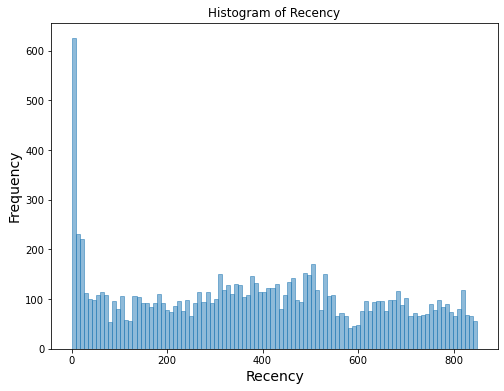

In [13]:
# #plot a recency histogram
plt.figure(figsize=(8,6))
plt.hist(Sclient['Recency'], bins=100, alpha=0.5, label="Recency", color = "tab:blue", ec="tab:blue")

plt.xlabel("Recency", size=14)
plt.ylabel("Frequency", size=14)
plt.title("Histogram of Recency")

plt.show()

In [14]:
Sclient.Recency.describe()

count   10,465.00
mean       381.21
std        248.79
min          0.00
25%        166.00
50%        381.00
75%        572.00
max        850.00
Name: Recency, dtype: float64

# K-means clustering to assign a recency score

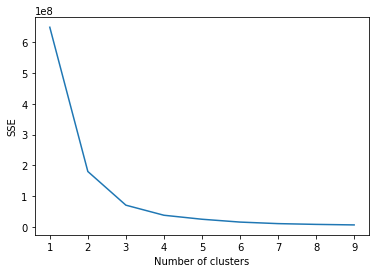

In [15]:
from sklearn.cluster import KMeans
# Generate clusters
sse={}
recency = Sclient[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(recency)
    recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel('SSE')
plt.show()

In [16]:
#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=3)
kmeans.fit(Sclient[['Recency']])
Sclient['RecencyCluster'] = kmeans.predict(Sclient[['Recency']])
Sclient.head()

,Client,Recency,RecencyCluster
0,12557,0,2
1,10981,0,2
2,2925,0,2
3,3465,4,2
4,9833,0,2


In [17]:
Sclient['RecencyCluster'].unique()

array([2, 0, 1], dtype=int32)

In [18]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [19]:
Sclient = order_cluster('RecencyCluster', 'Recency',Sclient,False)

In [20]:
Sclient['RecencyCluster'].describe()

count   10,465.00
mean         1.07
std          0.77
min          0.00
25%          0.00
50%          1.00
75%          2.00
max          2.00
Name: RecencyCluster, dtype: float64

In [21]:
Sclient.head()

,Client,Recency,RecencyCluster
0,12557,0,2
1,10981,0,2
2,2925,0,2
3,3465,4,2
4,9833,0,2


In [22]:
#see dnumber of clients by Recency cluster
Sclient.groupby('RecencyCluster')['Recency'].count()

RecencyCluster
0    2757
1    4205
2    3503
Name: Recency, dtype: int64

# Frequency

In [23]:
#get order counts for each client and create a dataframe with it
Sfrequency = data.groupby('Client').Date.count().reset_index()
Sfrequency.columns = ['Client','Frequency']
Sfrequency.head()

,Client,Frequency
0,1,679
1,2,2
2,3,6
3,4,2
4,5,2


In [24]:
Sfrequency.tail()

,Client,Frequency
10460,14969,1
10461,14970,1
10462,14971,1
10463,14972,1
10464,14973,62


In [25]:
#add this data to our main dataframe
Sclient = pd.merge(Sclient, Sfrequency, on='Client')

In [26]:
Sclient.head()

,Client,Recency,RecencyCluster,Frequency
0,12557,0,2,18164
1,10981,0,2,950
2,2925,0,2,973
3,3465,4,2,642
4,9833,0,2,6432


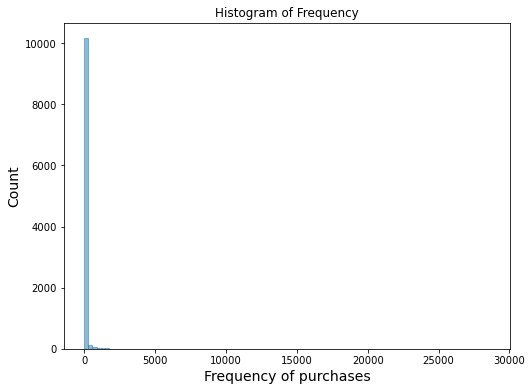

In [27]:
# Frequency histogram
plt.figure(figsize=(8,6))
plt.hist(Sclient['Frequency'], bins=100, alpha=0.5, label="Frequency", color = "tab:blue", ec="tab:blue")

plt.xlabel("Frequency of purchases", size=14)
plt.ylabel("Count", size=14)
plt.title("Histogram of Frequency")

plt.show()


In [28]:
#k-means
kmeans = KMeans(n_clusters=3)
kmeans.fit(Sclient[['Frequency']])
Sclient['FrequencyCluster'] = kmeans.predict(Sclient[['Frequency']])


In [29]:
#order the frequency cluster
Sclient = order_cluster('FrequencyCluster', 'Frequency',Sclient,True)

In [30]:
Sclient.head()

,Client,Recency,RecencyCluster,Frequency,FrequencyCluster
0,12557,0,2,18164,2
1,5828,0,2,9538,2
2,11368,0,2,11124,2
3,3311,0,2,11612,2
4,5633,0,2,9656,2


In [31]:
#see details of each cluster
Sclient.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,"10,390.00",23.64,107.94,1.00,1.00,1.00,4.00,"1,532.00"
1,62.00,"3,074.05","1,297.09","1,583.00","2,054.25","2,758.00","3,805.25","7,343.00"
2,13.00,"12,200.31","5,506.22","8,492.00","9,551.00","10,544.00","11,612.00","28,646.00"


# Monetary value (Sales)

In [32]:
#calculate revenue for each customer
Ssales = data.groupby('Client').Sales.sum().reset_index()
Ssales.tail()

,Client,Sales
10460,14969,0.25
10461,14970,0.41
10462,14971,0.42
10463,14972,0.42
10464,14973,351.86


In [33]:
#merge it with our main dataframe
Sclient = pd.merge(Sclient, Ssales, on='Client')

In [34]:
Sclient.head()

,Client,Recency,RecencyCluster,Frequency,FrequencyCluster,Sales
0,12557,0,2,18164,2,"9,227.01"
1,5828,0,2,9538,2,"7,090.73"
2,11368,0,2,11124,2,"5,764.14"
3,3311,0,2,11612,2,"16,928.28"
4,5633,0,2,9656,2,"3,251.79"


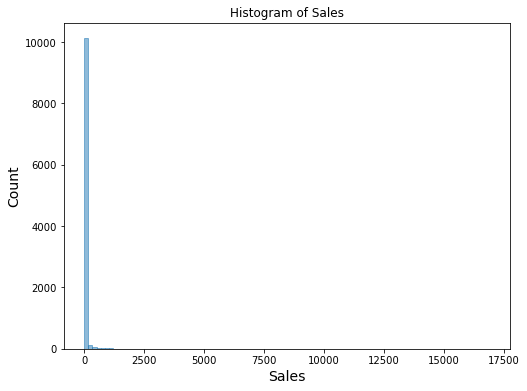

In [35]:
# Frequency histogram for sales
plt.figure(figsize=(8,6))
plt.hist(Sclient['Sales'], bins=100, alpha=0.5, label="Sales", color = "tab:blue", ec="tab:blue")

plt.xlabel("Sales", size=14)
plt.ylabel("Count", size=14)
plt.title("Histogram of Sales")

plt.show()

In [36]:
#apply clustering
kmeans = KMeans(n_clusters=3)
kmeans.fit(Sclient[['Sales']])
Sclient['SalesCluster'] = kmeans.predict(Sclient[['Sales']])


In [37]:
#order the cluster numbers
Sclient = order_cluster('SalesCluster', 'Sales',Sclient,True)

In [38]:
#Sclient.head()

In [39]:
#show details of the dataframe
Sclient.groupby('SalesCluster')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
SalesCluster,,,,,,,,
0,"10,396.00",17.49,82.08,0.20,0.38,0.80,2.86,"1,134.86"
1,56.00,"2,338.49",959.13,"1,220.17","1,698.32","2,032.38","2,832.43","5,324.43"
2,13.00,"8,469.49","3,703.12","5,553.15","6,239.16","7,090.73","8,217.31","16,928.28"


# Calculate RFM Score

In [40]:
#calculate overall score and use mean() to see details
Sclient['OverallScore'] = Sclient['RecencyCluster'] + Sclient['FrequencyCluster'] + Sclient['SalesCluster']
#Sclient.groupby('OverallScore')['Recency','Frequency','Sales'].mean()
Sclient.groupby(['OverallScore'])[['Recency','Frequency','Sales']].mean()

,Recency,Frequency,Sales
OverallScore,,,
0,704.89,2.31,1.78
1,406.47,4.19,3.54
2,98.41,61.86,42.99
3,17.64,"1,593.64","1,336.73"
4,0.89,"3,495.45","2,395.86"
5,0.00,"6,025.00","5,734.55"
6,0.00,"12,412.33","8,490.50"


In [41]:
#Name as Low, Medium and High Value
Sclient['Segment'] = 'Low-Value'
Sclient.loc[Sclient['OverallScore']>2,'Segment'] = 'Mid-Value' 
Sclient.loc[Sclient['OverallScore']>4,'Segment'] = 'High-Value'

In [42]:
Sclient.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10465 entries, 0 to 10464
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Client            10465 non-null  int64  
 1   Recency           10465 non-null  int64  
 2   RecencyCluster    10465 non-null  int64  
 3   Frequency         10465 non-null  int64  
 4   FrequencyCluster  10465 non-null  int64  
 5   Sales             10465 non-null  float64
 6   SalesCluster      10465 non-null  int64  
 7   OverallScore      10465 non-null  int64  
 8   Segment           10465 non-null  object 
dtypes: float64(1), int64(7), object(1)
memory usage: 817.6+ KB


In [43]:
Sclient.head(5)

,Client,Recency,RecencyCluster,Frequency,FrequencyCluster,Sales,SalesCluster,OverallScore,Segment
0,12557,0,2,18164,2,"9,227.01",2,6,High-Value
1,5828,0,2,9538,2,"7,090.73",2,6,High-Value
2,11368,0,2,11124,2,"5,764.14",2,6,High-Value
3,3311,0,2,11612,2,"16,928.28",2,6,High-Value
4,1160,0,2,8616,2,"7,822.55",2,6,High-Value


In [44]:
Sclient.tail(5)

,Client,Recency,RecencyCluster,Frequency,FrequencyCluster,Sales,SalesCluster,OverallScore,Segment
10460,11049,0,2,1648,1,681.16,0,3,Mid-Value
10461,2263,4,2,1749,1,607.88,0,3,Mid-Value
10462,6204,10,2,1749,1,"1,090.79",0,3,Mid-Value
10463,11760,0,2,2033,1,"1,024.88",0,3,Mid-Value
10464,6121,1,2,2038,1,568.51,0,3,Mid-Value


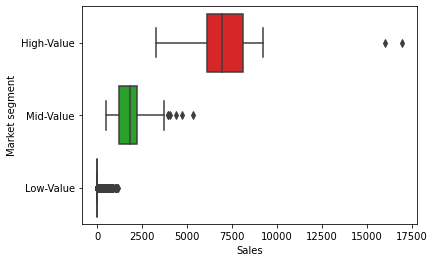

In [45]:
#Boxplot of Market Segment by Sales
ax= sns.boxplot(y='Segment',x='Sales',data=Sclient, notch=False)

# Change the appearance of that box
ax.artists[0].set_facecolor('tab:red')
ax.artists[1].set_facecolor('tab:blue')
ax.artists[1].set_facecolor('tab:green')

ax.set_xlabel("Sales", fontsize = 10)
ax.set_ylabel("Market segment", fontsize = 10)
plt.show()

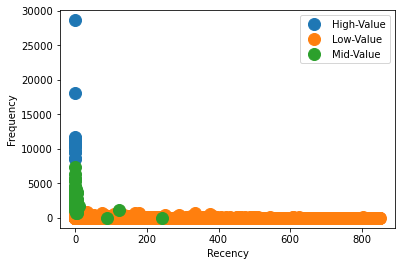

In [46]:
groups = Sclient.groupby('Segment')
for name, group in groups:
    plt.plot(group.Recency, group.Frequency, marker='o', linestyle='', markersize=12, label=name)
plt.xlabel("Recency", fontsize = 10)
plt.ylabel("Frequency", fontsize = 10)
plt.legend()

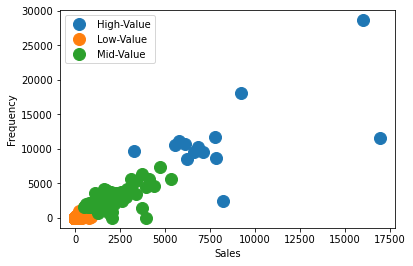

In [47]:
for name, group in groups:
    plt.plot(group.Sales, group.Frequency, marker='o', linestyle='', markersize=12, label=name)
plt.xlabel("Sales", fontsize = 10)
plt.ylabel("Frequency", fontsize = 10)
plt.legend()

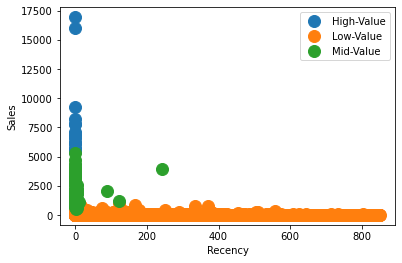

In [48]:
for name, group in groups:
    plt.plot(group.Recency, group.Sales, marker='o', linestyle='', markersize=12, label=name)
plt.xlabel("Recency", fontsize = 10)
plt.ylabel("Sales", fontsize = 10)
plt.legend()